<a href="https://colab.research.google.com/github/swilsonmfc/deeplearning/blob/master/BostonKerasRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
* Boston Home Prices Data
* Simple Neural Network
* Fully Connected (Dense 1 Node Output)


In [0]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import boston_housing

from keras import models
from keras import losses
from keras import layers
from keras import metrics
from keras import optimizers

# Data

In [0]:
[train_data, train_targets], [test_data, test_targets] = boston_housing.load_data()

In [0]:
train_data.shape

(404, 13)

In [0]:
test_data.shape

(102, 13)

# Preprocessing
* Scale numeric data

In [0]:
mean = train_data.mean(axis=0)
std  = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

# Model

In [0]:
def buildModel():  
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizers.RMSprop(lr=0.001),
                losses.MAE,
                [metrics.MAE])
  return model

# K-Fold Validation
* Using basic numpy (rather than sklearn) 

In [0]:
k = 4
samples = len(train_data) // k
epochs  = 100
all_scores = []

for i in range(k):
  print('Processing Fold', i)
  val_data    = train_data[i * samples: (i + 1) * samples]
  val_targets = train_targets[i * samples: (i + 1) * samples]
  
  X_train = np.concatenate([
      train_data[: i * samples],
      train_data[(i + 1) * samples:]
  ], axis=0)
  y_train = np.concatenate([
      train_targets[: i * samples],
      train_targets[(i + 1) * samples:]
  ], axis=0)
  
  model = buildModel()
  model.fit(X_train, 
            y_train,
            epochs=epochs,
            batch_size=1,
            verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)
  print('Fold Validation MAE', val_mae)
  
print('Fold Scores', all_scores)
print('MAE', np.mean(all_scores))

Processing Fold 0
Fold Validation MAE 2.000725507736206
Processing Fold 1
Fold Validation MAE 2.3995927631264866
Processing Fold 2
Fold Validation MAE 2.5453272172720127
Processing Fold 3
Fold Validation MAE 2.7038130240865272
Fold Scores [2.000725507736206, 2.3995927631264866, 2.5453272172720127, 2.7038130240865272]
MAE 2.412364628055308


# Validation Logging
* Pretty high error
* Increase the epochs (how does longer training affect performance)
* Log validation scores to detect where we might be overfitting
* Not going to run early-stop

In [0]:
k = 4
samples = len(train_data) // k
epochs  = 500
all_mae_history = []

for i in range(k):
  print('Processing Fold', i)
  val_data    = train_data[i * samples: (i + 1) * samples]
  val_targets = train_targets[i * samples: (i + 1) * samples]
  
  X_train = np.concatenate([
      train_data[: i * samples],
      train_data[(i + 1) * samples:]
  ], axis=0)
  y_train = np.concatenate([
      train_targets[: i * samples],
      train_targets[(i + 1) * samples:]
  ], axis=0)
  
  model = buildModel()
  history = model.fit(X_train, 
                    y_train,
                    epochs=epochs,
                    batch_size=1,
                    verbose=0,
                    validation_data=[val_data, val_targets])
  mae_history = history.history['val_mean_absolute_error']
  all_mae_history.append(mae_history)
  
mean_mae_history = [np.mean([x[i] for x in all_mae_history]) for i in range(epochs)]

Processing Fold 0
Processing Fold 1
Processing Fold 2
Processing Fold 3


# Plot MAE over Epochs

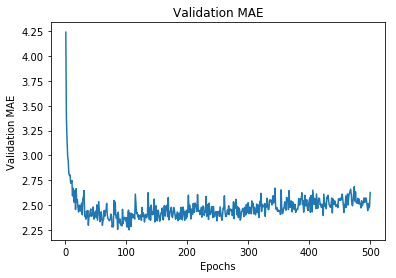

In [0]:
plt.plot(range(1, len(mean_mae_history) + 1), mean_mae_history)
plt.title('Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Plot Smoothed MAE over Epochs
* Knock out early points
* Smooth remaining data

In [0]:
def smooth(points, factor=0.9):
  smoothed = []
  for point in points:
    if smoothed:
      previous = smoothed[-1]
      smoothed.append(previous * factor + point * (1 - factor))
    else:
      smoothed.append(point)
  return smoothed

In [0]:
smoothed_history = smooth(mean_mae_history[10:])

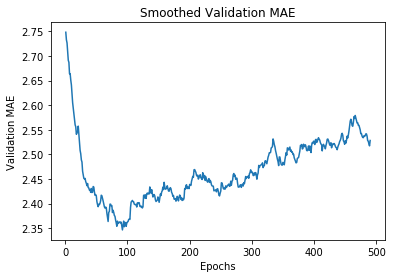

In [0]:
plt.plot(range(1, len(smoothed_history) + 1), smoothed_history)
plt.title('Smoothed Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Test Data
* Train for 90-100 epochs
* Evaluate on test data

In [0]:
model = buildModel()
model.fit(train_data, 
         train_targets,
         epochs=95,
         batch_size=10,
         verbose=0)
test_mse, test_mae = model.evaluate(test_data, test_targets)
print('Test MSE', test_mse)
print('Test MAE', test_mae)

102/102 [==============================] - 0s 4ms/step
Test MSE 2.7010893073736453
Test MAE 2.7010893073736453


# Conclusion
* Our model is off on average by about $2,700